based on https://jhat.readthedocs.io/en/latest/examples/plot_b_nircam.html

In [1]:
%matplotlib inline


# JWST NIRCAM

Aligning JWST/NIRCAM images with JHAT.


An example NIRCam Dataset is downloaded, and then a series of
alignment methods are used. For more information on the
key parameters used for alignment see 
`params:Useful Parameters`.



In [2]:
import sys,os,glob
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.nddata import extract_array
from astropy.coordinates import SkyCoord
from astropy import wcs
from astropy.wcs.utils import skycoord_to_pixel
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from astroquery.mast import Observations
from astropy.visualization import (simple_norm,LinearStretch)
from astroquery.gaia import Gaia

import jhat
from jhat import jwst_photclass,st_wcs_align

from nbutils import xmatch_common



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


## Relative Alignment

**Download some Data**

For this example we download 2 JWST NIRCam images from MAST. They're
the same field but different filters. Note that 
the code will also work for level 3 data images.



In [17]:
obs_table1 = Observations.query_criteria(obs_id='jw02107-o041_t019_nircam_clear-f200w')
data_products_by_obs = Observations.get_product_list(obs_table1)
data_products_by_obs = data_products_by_obs[data_products_by_obs['calib_level']==2]
data_products_by_obs = data_products_by_obs[data_products_by_obs['productSubGroupDescription']=='CAL']
data_products_by_obs = data_products_by_obs[data_products_by_obs['obs_id']=='jw02107041001_02101_00001_nrcb1']

In [18]:
data_products_by_obs

<Table masked=True length=1>
 obsID   obs_collection dataproduct_type ... dataRights calib_level filters
  str8        str4            str5       ...    str6       int64      str5 
-------- -------------- ---------------- ... ---------- ----------- -------
87617603           JWST            image ...     PUBLIC           2   F200W

In [19]:
Observations.download_products(data_products_by_obs,extension='fits')

<Table length=1>
                                         Local Path                                          ...
                                           str92                                             ...
-------------------------------------------------------------------------------------------- ...
./mastDownload/JWST/jw02107041001_02101_00001_nrcb1/jw02107041001_02101_00001_nrcb1_cal.fits ...

In [20]:
obs_table2 = Observations.query_criteria(obs_id='jw02107-o041_t019_nircam_clear-f360m')
data_products_by_obs = Observations.get_product_list(obs_table2)
data_products_by_obs = data_products_by_obs[data_products_by_obs['calib_level']==2]
data_products_by_obs = data_products_by_obs[data_products_by_obs['productSubGroupDescription']=='CAL']
data_products_by_obs = data_products_by_obs[data_products_by_obs['obs_id']=='jw02107041001_02101_00001_nrcblong']

In [21]:
data_products_by_obs

<Table masked=True length=1>
 obsID   obs_collection dataproduct_type ... dataRights calib_level filters
  str8        str4            str5       ...    str6       int64      str5 
-------- -------------- ---------------- ... ---------- ----------- -------
87617252           JWST            image ...     PUBLIC           2   F360M

In [22]:
Observations.download_products(data_products_by_obs,extension='fits')

<Table length=1>
                                            Local Path                                             ...
                                              str98                                                ...
-------------------------------------------------------------------------------------------------- ...
./mastDownload/JWST/jw02107041001_02101_00001_nrcblong/jw02107041001_02101_00001_nrcblong_cal.fits ...

**Examine the Reference Image**




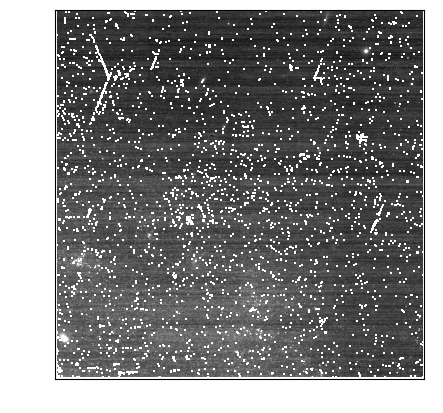

In [3]:
ref_image = glob.glob('jwstred_temp/jw02107041001_02101_00001_nrcb1_cal.fits')[0]

ref_fits = fits.open(ref_image)
ref_data = fits.open(ref_image)['SCI',1].data
norm1 = simple_norm(ref_data,stretch='linear',min_cut=-.5,max_cut=3)

plt.imshow(ref_data, origin='lower',
                      norm=norm1,cmap='gray')
plt.gca().tick_params(labelcolor='none',axis='both',color='none')
plt.show()

**Zoom in to see the offset**

Here add an artificial offset to the wcs, and then we see the 
same star in both images at the same ra/dec
location, demonstrating a large offset between
the images.  



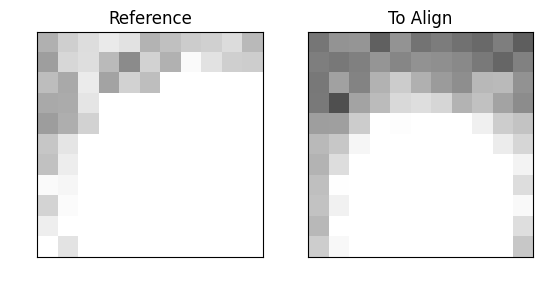

In [24]:
star_location = SkyCoord('23:09:41.0532','-43:26:41.128',unit=(u.hourangle,u.deg))
align_image = glob.glob('jwstred_temp/jw02107041001_02101_00001_nrcblong_cal.fits')[0]
align_fits = fits.open(align_image)
align_fits['SCI',1].header['CRPIX1']+=1
align_fits['SCI',1].header['CRPIX2']+=1
align_fits.writeto(align_image,overwrite=True)

align_data = fits.open(align_image)['SCI',1].data
ref_y,ref_x = skycoord_to_pixel(star_location,wcs.WCS(ref_fits['SCI',1],ref_fits))
align_y,align_x = skycoord_to_pixel(star_location,wcs.WCS(align_fits['SCI',1],align_fits))

ref_cutout = extract_array(ref_data,(11,11),(ref_x,ref_y))
align_cutout = extract_array(align_data,(11,11),(align_x,align_y))
norm1 = simple_norm(ref_cutout,stretch='linear',min_cut=-.5,max_cut=3)
norm2 = simple_norm(align_cutout,stretch='linear',min_cut=-.5,max_cut=3)
fig,axes = plt.subplots(1,2)
axes[0].imshow(ref_cutout, origin='lower',
                      norm=norm1,cmap='gray')
axes[1].imshow(align_cutout, origin='lower',
                      norm=norm2,cmap='gray')
axes[0].set_title('Reference')
axes[1].set_title('To Align')
axes[0].tick_params(labelcolor='none',axis='both',color='none')
axes[1].tick_params(labelcolor='none',axis='both',color='none')

plt.show()

**Create a Photometric Catalog for Relative Alignment**

We choose one of the images to be the reference image, and then 
create a catalog that we will use to align the other image.



In [3]:
ref_image = glob.glob('jwstred_temp_gaia/jw01334001001_04101_00001_nrca4_cal.fits')[0]

In [4]:
jwst_phot = jwst_photclass()
jwst_phot.run_phot(imagename=ref_image,photfilename='auto',overwrite=True,ee_radius=80)
ref_catname = ref_image.replace('.fits','.phot.txt') # the default
refcat = Table.read(ref_catname,format='ascii')
print(refcat)

0 jwstred_temp_gaia/jw01334001001_04101_00001_nrca4_cal.phot.txt


2024-09-25 17:26:55,101 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.
2024-09-25 17:26:56,721 - stpipe.SourceCatalogStep - INFO - Using APCORR reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_apcorr_0004.fits
2024-09-25 17:26:56,740 - stpipe.SourceCatalogStep - INFO - Using ABVEGAOFFSET reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_abvegaoffset_0002.asdf
2024-09-25 17:26:56,741 - stpipe - INFO - Instrument: NIRCAM
2024-09-25 17:26:56,743 - stpipe - INFO - Detector: NRCA4
2024-09-25 17:26:56,743 - stpipe - INFO - Filter: F150W
2024-09-25 17:26:56,744 - stpipe - INFO - Pupil: CLEAR
2024-09-25 17:26:56,745 - stpipe - INFO - Subarray: FULL
2024-09-25 17:26:56,812 - stpipe - WARNING - model.meta.resample.pixel_scale_ratio was not found. Assuming the native detector pixel scale (i.e., pixel_scale_ratio = 1)


dmag 0.36200000000000004
aper_sum_6.1px annulus_median_6.1px aper_bkg_6.1px ...   x_idl      y_idl   
-------------- -------------------- -------------- ... ---------- ----------
    444.290502             1.181516     137.303718 ... -19.508799 -31.430415
    255.341323             1.672677     194.381428 ... -15.303636 -31.447672
    322.843356             1.023311     118.918788 ... -10.052393 -31.508675
    935.162095             1.252344     145.534634 ...  -6.302938 -31.520173
    454.029922             1.754369      203.87489 ...   7.807392 -31.562027
    931.168329             1.962583     228.071343 ...   7.934563 -31.539268
    874.915341             2.665625     309.771688 ...   8.726442 -31.521371
    389.614453             3.158343     367.030376 ...   9.811565 -31.530888
    472.914933             2.674495     310.802441 ...  10.499776 -31.572552
    840.968235             2.534756     294.563482 ...  13.865154 -31.550376
           ...                  ...            ... 

**Align the second image**

The plots outputted here show the various steps used by jhat to
determine the true matching sources in the image, and the
subsequent correction needed for optimal alignment.



In [5]:
align_image = glob.glob('jwstred_temp_gaia/jw01334001001_02101_00002_nrca4_cal.fits')[0]
# align_image = glob.glob('jwstred_temp_gaia/jw01334001001_04101_00001_nrca4_cal.fits')[0]

0 ./jwstred_temp_gaia/jw01334001001_02101_00002_nrca4.phot.txt


2024-09-25 17:27:31,506 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.
2024-09-25 17:27:31,765 - stpipe.SourceCatalogStep - INFO - Using APCORR reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_apcorr_0004.fits
2024-09-25 17:27:31,780 - stpipe.SourceCatalogStep - INFO - Using ABVEGAOFFSET reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_abvegaoffset_0002.asdf
2024-09-25 17:27:31,781 - stpipe - INFO - Instrument: NIRCAM
2024-09-25 17:27:31,783 - stpipe - INFO - Detector: NRCA4
2024-09-25 17:27:31,784 - stpipe - INFO - Filter: F090W
2024-09-25 17:27:31,785 - stpipe - INFO - Pupil: CLEAR
2024-09-25 17:27:31,786 - stpipe - INFO - Subarray: FULL
2024-09-25 17:27:31,833 - stpipe - WARNING - model.meta.resample.pixel_scale_ratio was not found. Assuming the native detector pixel scale (i.e., pixel_scale_ratio = 1)


dmag 0.2172
dmag 0.1
sharpness 0.9
roundness1 0.7
mag 21
x 2008
y 2008
reffile_d2d 0.15
*** Note: close plot to continue!


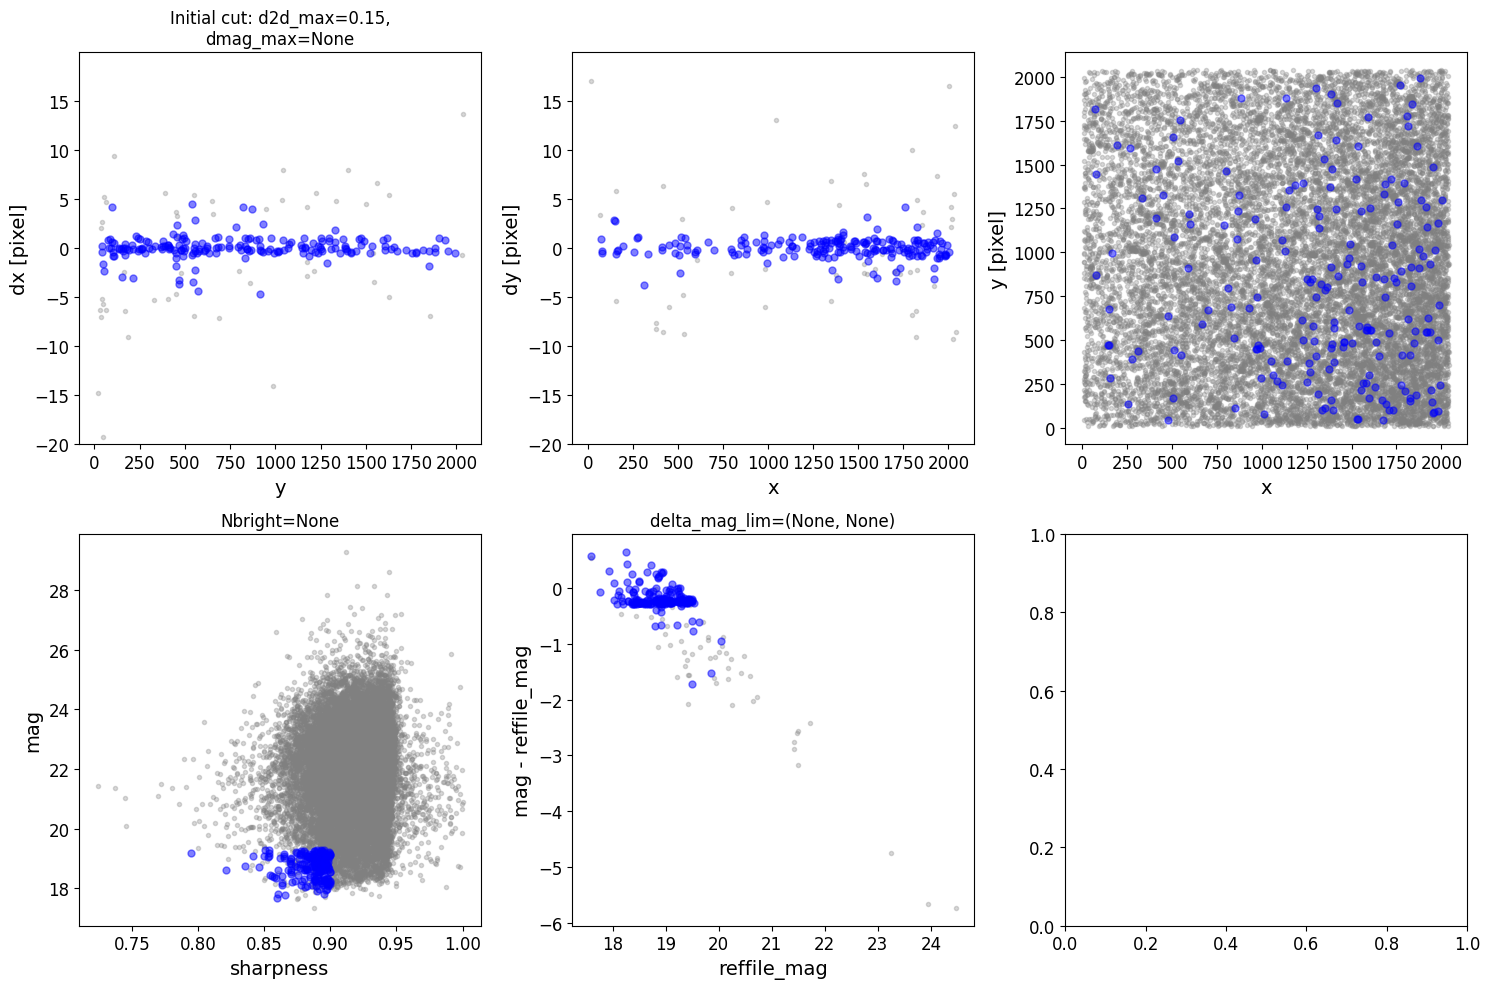

    slope  intercept  maxval  index  d_bestguess  fwhm  multimax
-0.000293        0.3    98.0      6    -0.379234   1.6     False
d_rot_tmp 0.42076593803428985
Keeping 131 out of 131, skippin 0 because of null values in columns d_rot_tmp
median: -0.254813
75.000000 percentile cut: max residual for cut: 0.359790
__tmp_residuals 0.35978954747057107
median: -0.259727
i:00 mean:-0.259727(0.017963) stdev:0.176920(0.012637) X2norm:0.99 Nchanged:0 Ngood:98 Nclip:33

mean: -0.231347
i:01 mean:-0.231347(0.022143) stdev:0.237460(0.015590) X2norm:1.00 Nchanged:18 Ngood:116 Nclip:15

mean: -0.206251
i:02 mean:-0.206251(0.024957) stdev:0.279027(0.017577) X2norm:1.00 Nchanged:10 Ngood:126 Nclip:5

mean: -0.218917
i:03 mean:-0.218917(0.026145) stdev:0.294645(0.018415) X2norm:1.00 Nchanged:2 Ngood:128 Nclip:3

mean: -0.225590
i:04 mean:-0.225590(0.026792) stdev:0.303121(0.018871) X2norm:1.00 Nchanged:1 Ngood:129 Nclip:2

mean: -0.232475
i:05 mean:-0.232475(0.027468) stdev:0.311982(0.019348) X2norm:1.0

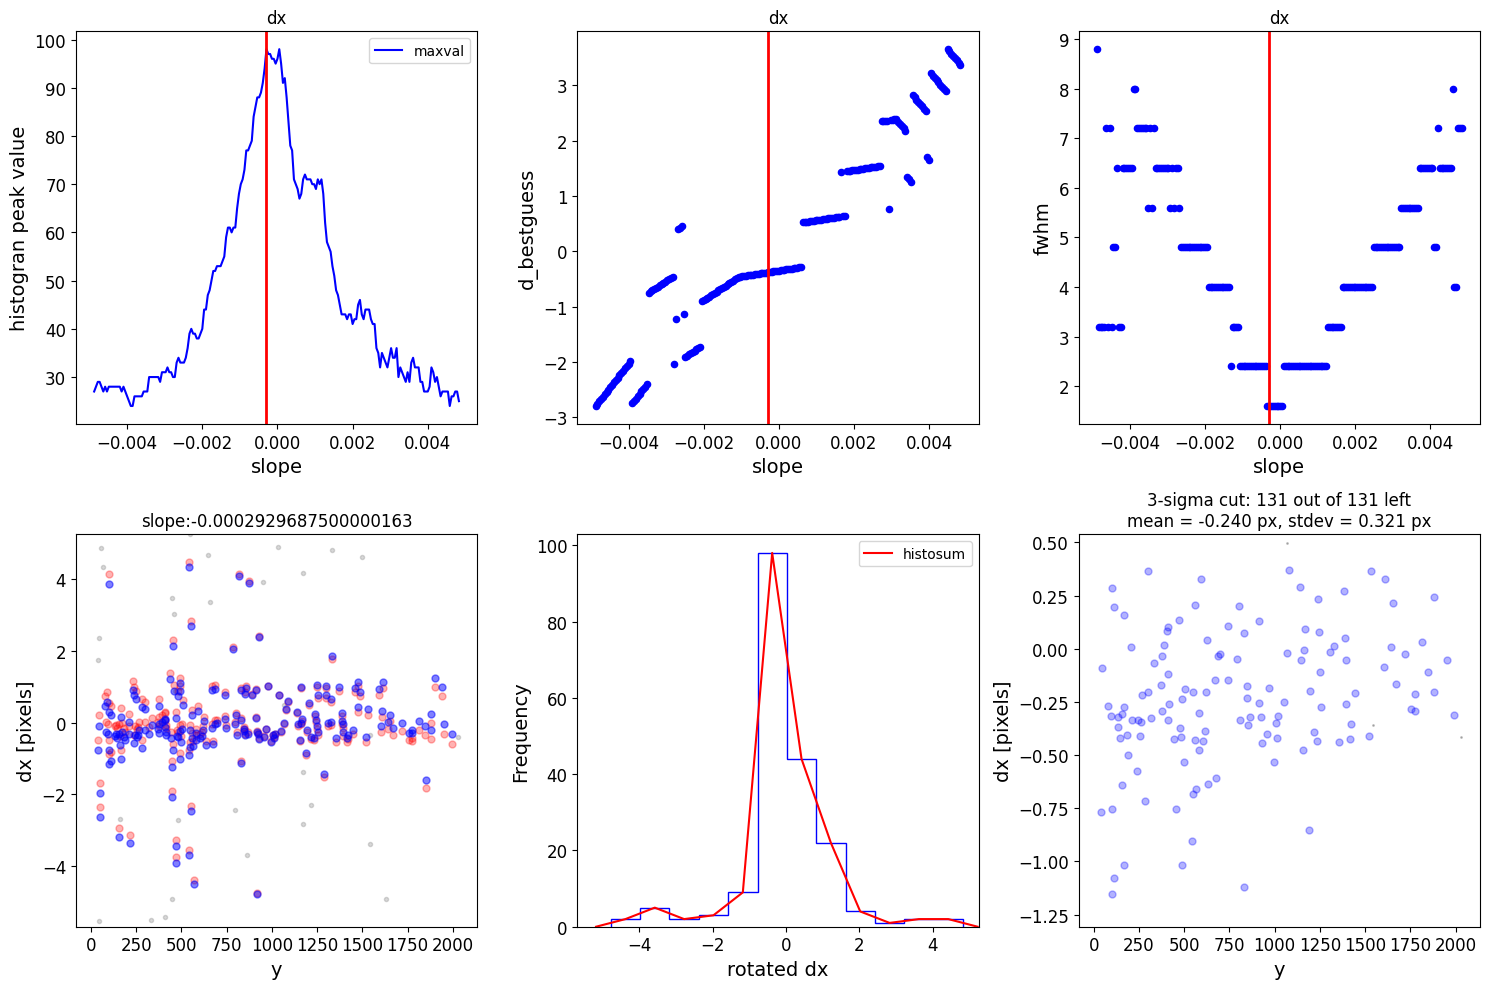

    slope  intercept  maxval  index  d_bestguess  fwhm  multimax
-0.000098        0.1    57.0      4    -0.522571   2.4     False
d_rot_tmp 0.27742948745703466
Keeping 73 out of 73, skippin 0 because of null values in columns d_rot_tmp
median: -0.417777
75.000000 percentile cut: max residual for cut: 0.360739
__tmp_residuals 0.3607390259177524
median: -0.465631
i:00 mean:-0.465631(0.030024) stdev:0.218576(0.021032) X2norm:0.99 Nchanged:0 Ngood:54 Nclip:19

mean: -0.432862
i:01 mean:-0.432862(0.035357) stdev:0.293698(0.024822) X2norm:1.00 Nchanged:16 Ngood:70 Nclip:3

mean: -0.405916
i:02 mean:-0.405916(0.037242) stdev:0.316006(0.026153) X2norm:1.00 Nchanged:3 Ngood:73 Nclip:0

mean: -0.405916
i:03 mean:-0.405916(0.037242) stdev:0.316006(0.026153) X2norm:1.00 Nchanged:0 Ngood:73 Nclip:0


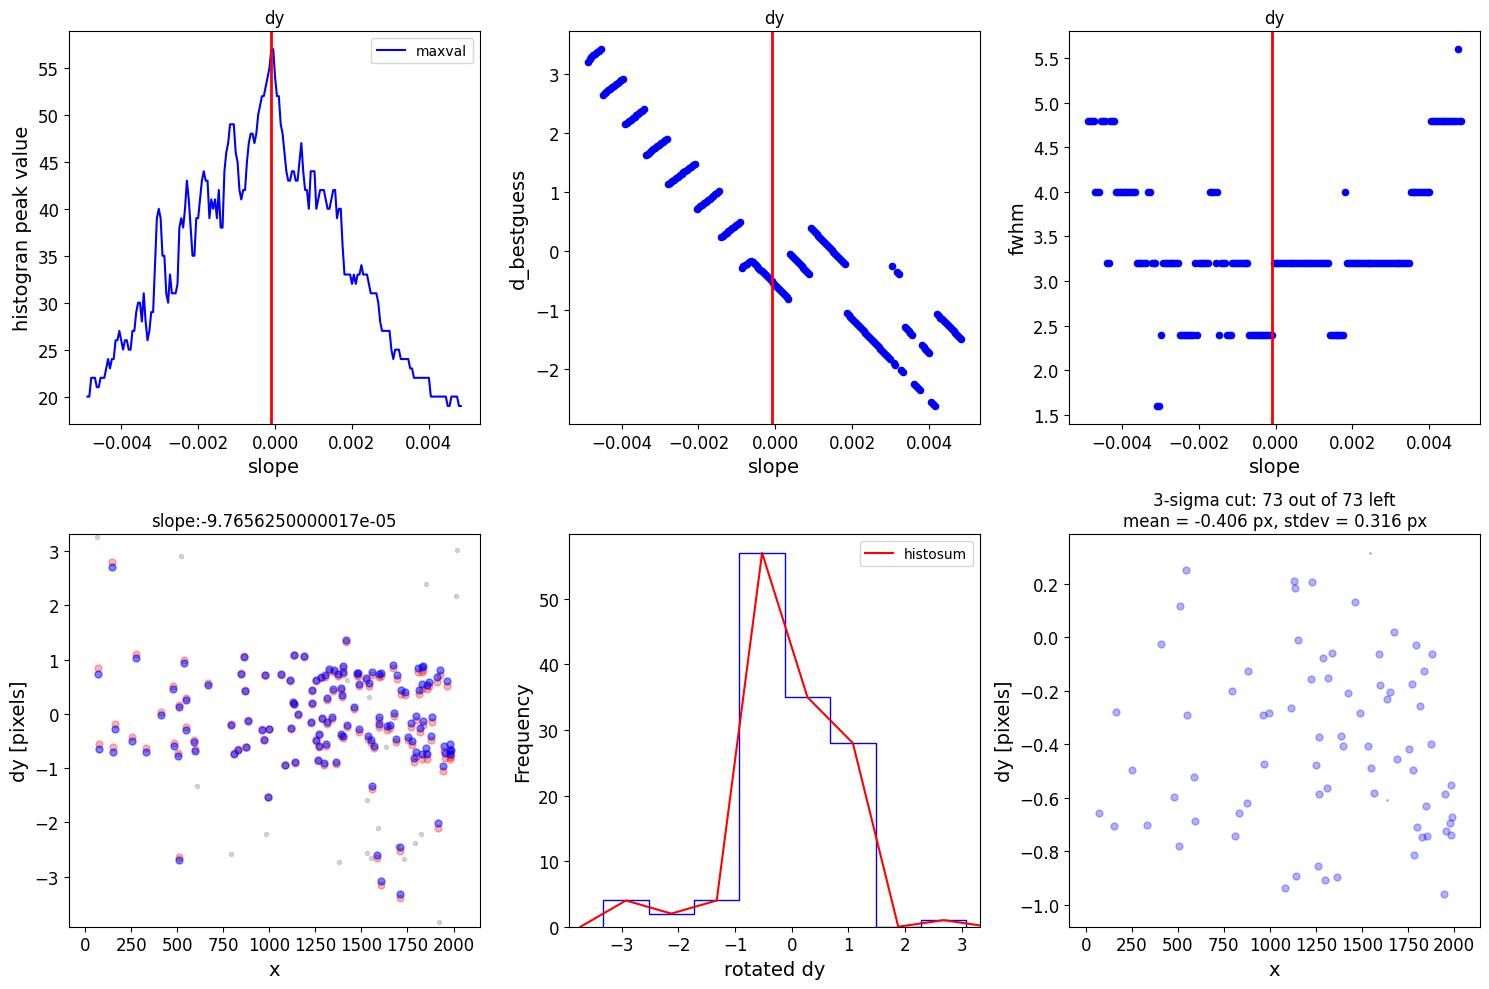

*** Note: close plots to continue!


<Figure size 640x480 with 0 Axes>

2024-09-25 17:27:54,500 - stpipe.TweakRegStep - INFO - TweakRegStep instance created.
2024-09-25 17:27:55,013 - stpipe.TweakRegStep - INFO - Step TweakRegStep running with args ([<ImageModel(2048, 2048) from jw01334001001_02101_00002_nrca4_cal.fits>],).
2024-09-25 17:27:55,018 - stpipe.TweakRegStep - INFO - Step TweakRegStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /home/aswin/hst123/jwstred_temp_gaia/jw01334001001_02101_00002_nrca4_jhat.fits
  output_dir: ./jwstred_temp_gaia
  output_ext: .fits
  output_use_model: True
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_catalogs: False
  catalog_format: ecsv
  kernel_fwhm: 2.5
  snr_threshold: 50
  brightest: 4000
  peakmax: None
  enforce_user_order: False
  expand_refcat: False
  minobj: 4
  searchrad: 0.5
  use2dhist: True
  separation: 9
  tolerance: 0.7
  xoffset: 0
  yoffset: 0
  fitgeometry: rshift
  nclip: 3
  sigma: 3.0
  align_to_

replacing SIP ./jwstred_temp_gaia/jw01334001001_02101_00002_nrca4_jhat.fits


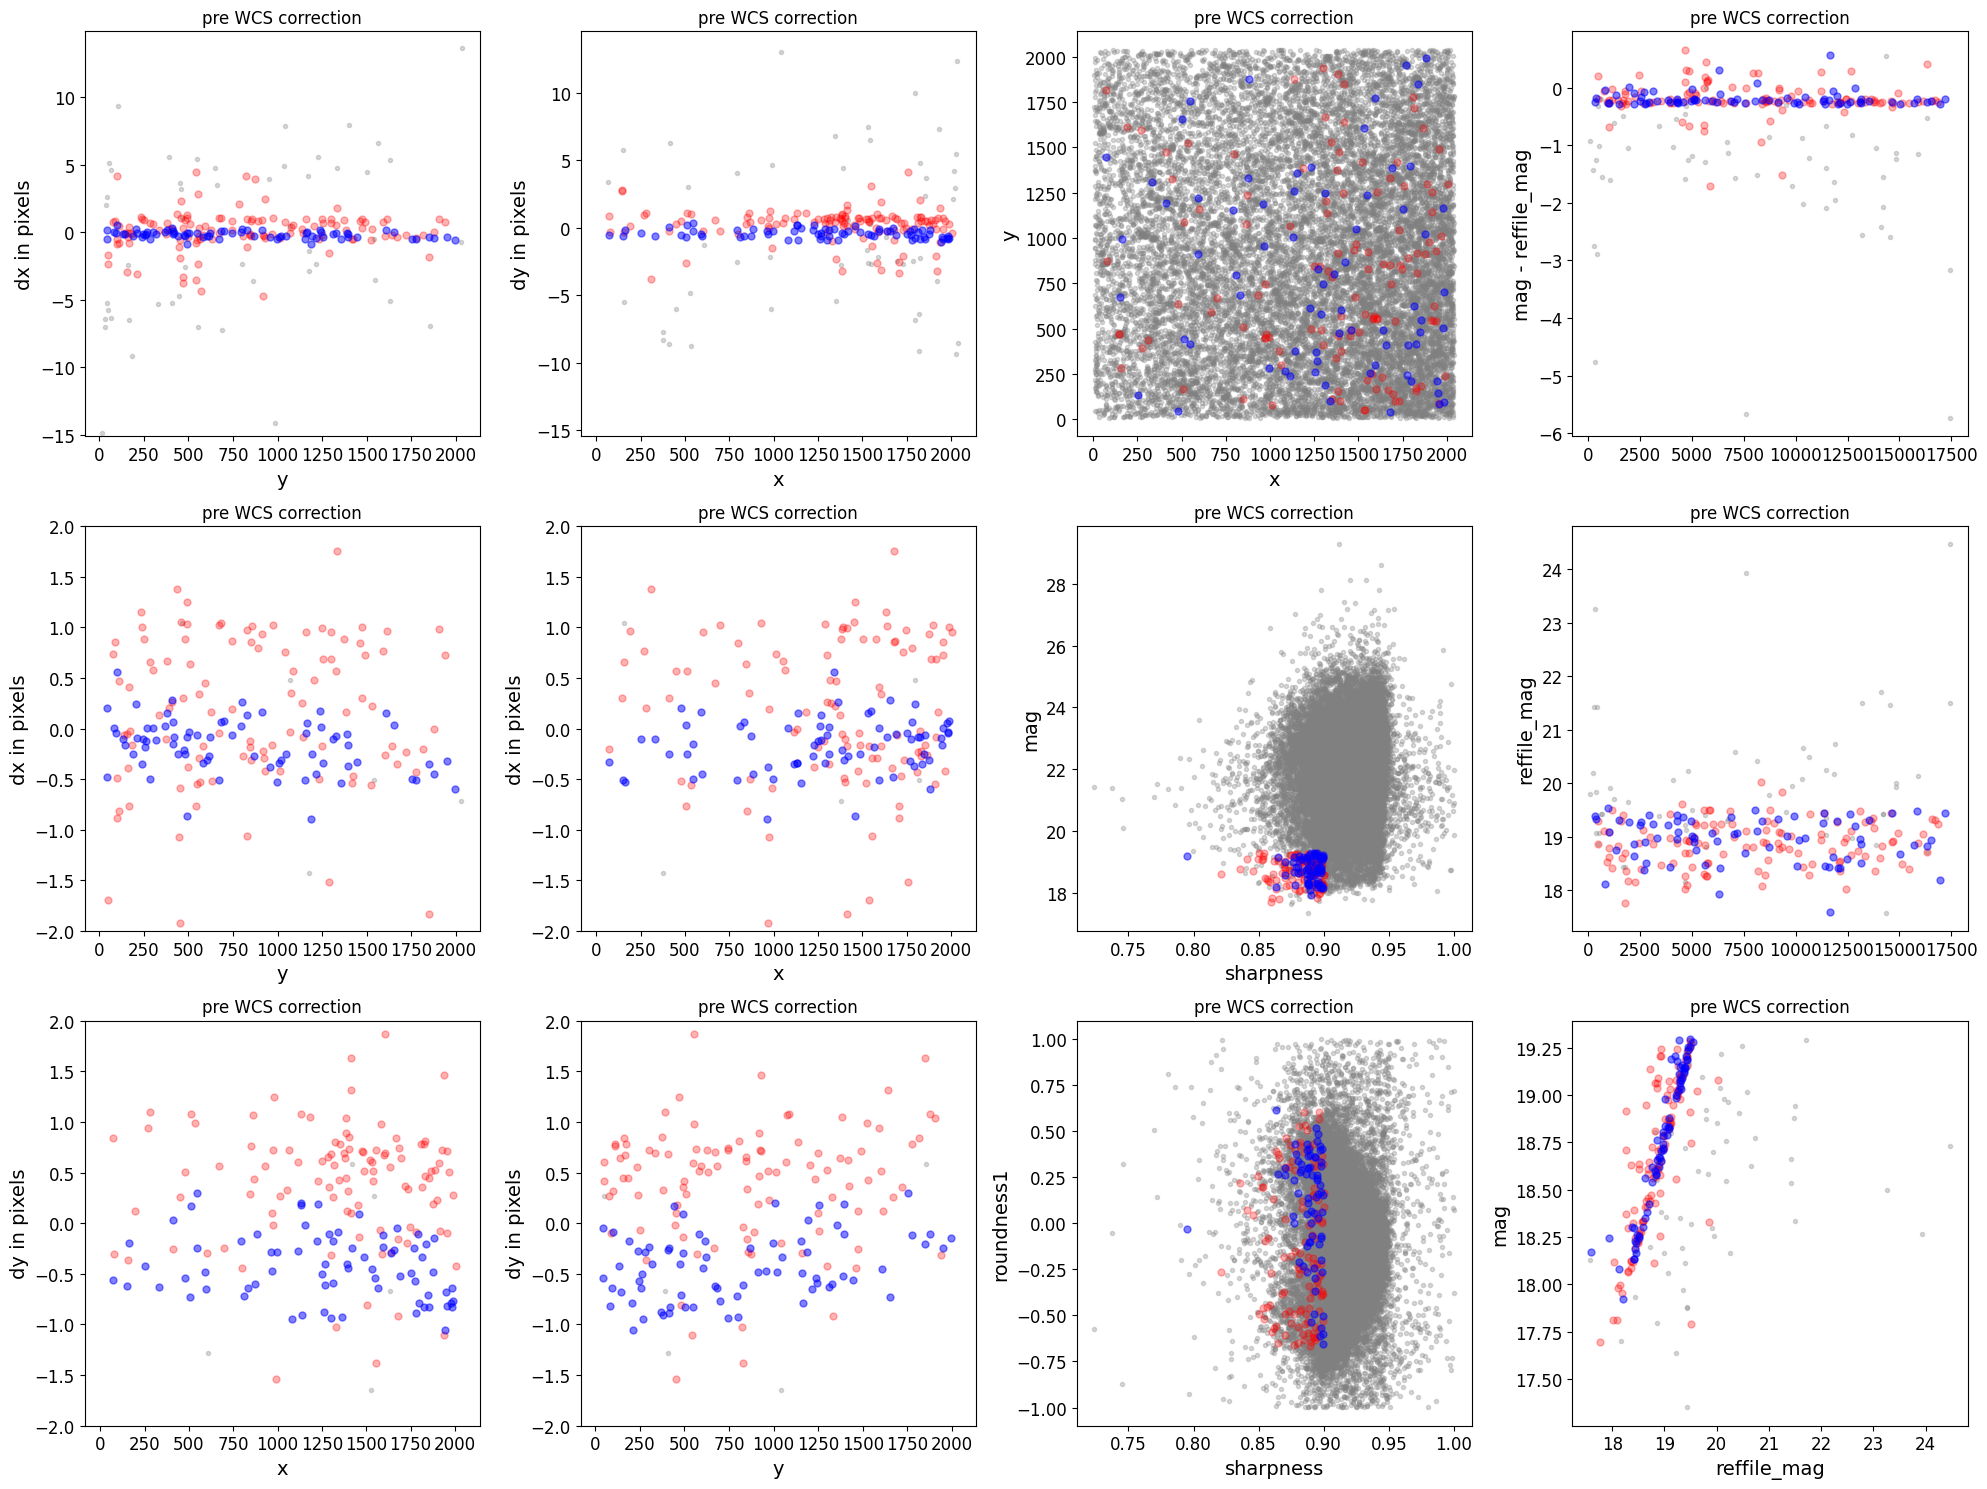

./jwstred_temp_gaia/jw01334001001_02101_00002_nrca4_jhat.fits


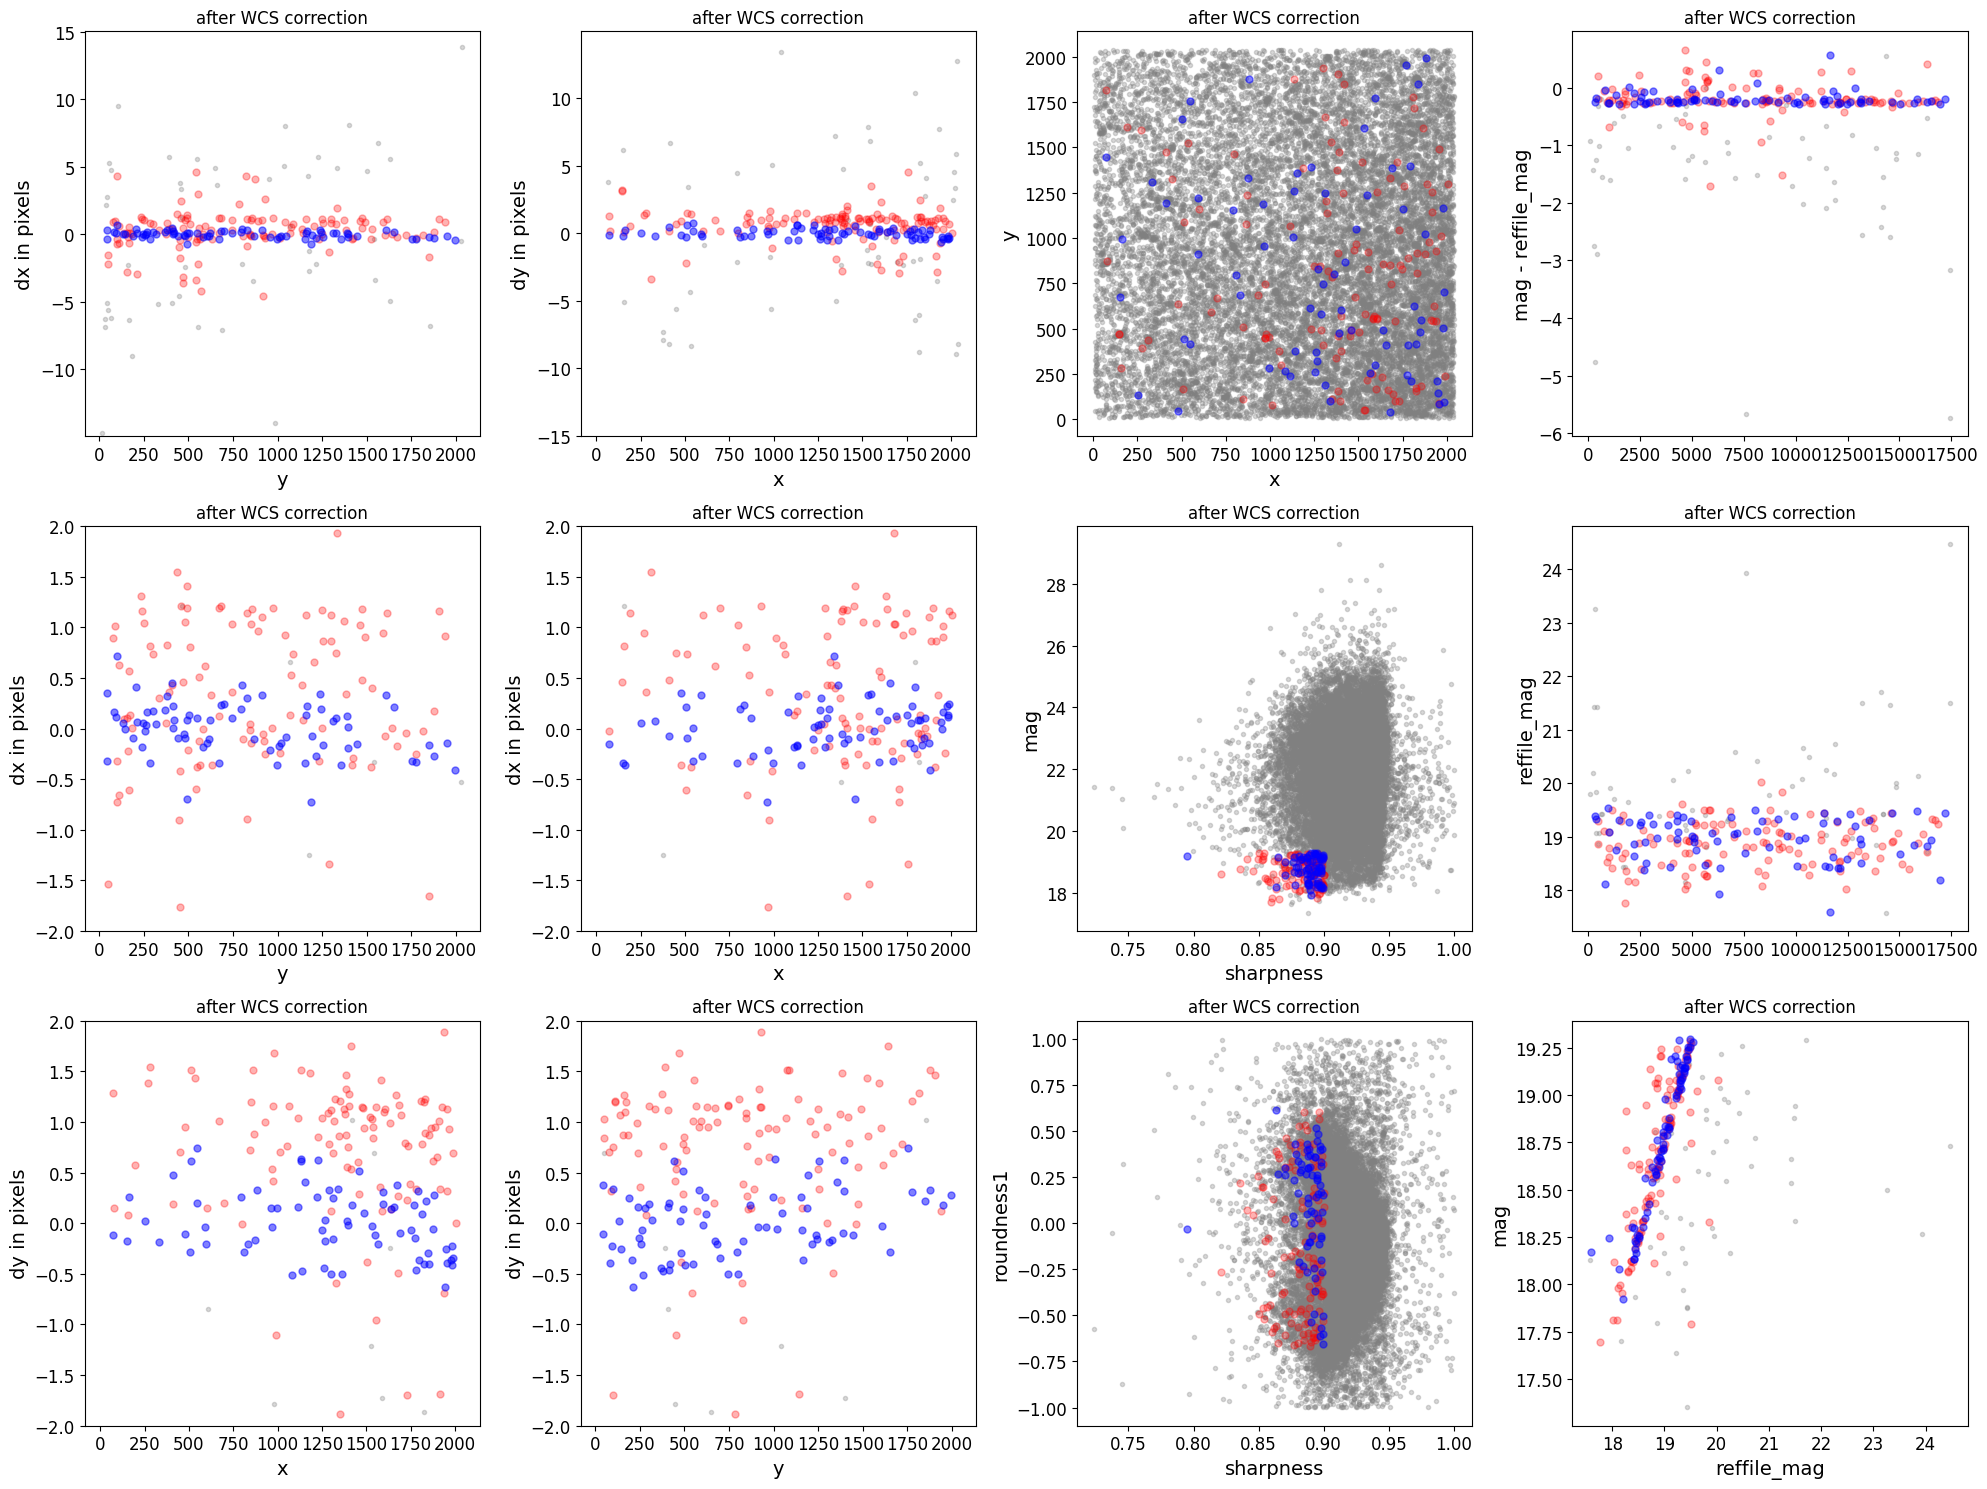

*** Note: close plots to continue!


0

In [6]:
wcs_align = st_wcs_align()


wcs_align.run_all(align_image,
		  telescope='jwst',
		  outsubdir='jwstred_temp_gaia',
          refcat_racol='ra',
          refcat_deccol='dec',
          refcat_magcol='mag',
          refcat_magerrcol='dmag',
          overwrite=True,
          d2d_max=.15,
          showplots=2,
          find_stars_threshold=5,
          refcatname=ref_catname,
          histocut_order='dxdy',
              sharpness_lim=(0.3,0.9),
              roundness1_lim=(-0.7, 0.7),
              SNR_min= 5,
              dmag_max=0.1,
              Nbright=250,
              objmag_lim =(14,21),
              binsize_px = 0.8)

**Check the Output**

The reference image has not changed, but let's read in the newly
aligned image and compare with the original. 
subsequent correction needed for optimal alignment.



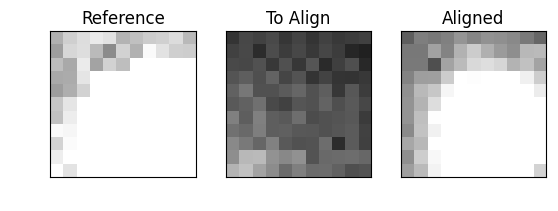

In [7]:
aligned_image = os.path.join('jwstred_temp',os.path.basename(align_image).replace('cal.fits','jhat.fits'))
aligned_fits = fits.open(aligned_image)
aligned_data = fits.open(aligned_image)['SCI',1].data
aligned_y,aligned_x = skycoord_to_pixel(star_location,wcs.WCS(aligned_fits['SCI',1],aligned_fits))
aligned_cutout = extract_array(aligned_data,(11,11),(aligned_x,aligned_y))

norm3 = simple_norm(aligned_cutout,stretch='linear',min_cut=-.5,max_cut=3)
fig,axes = plt.subplots(1,3)
axes[0].imshow(ref_cutout, origin='lower',
                      norm=norm1,cmap='gray')
axes[1].imshow(align_cutout, origin='lower',
                      norm=norm2,cmap='gray')
axes[2].imshow(aligned_cutout, origin='lower',
                      norm=norm3,cmap='gray')
axes[0].set_title('Reference')
axes[1].set_title('To Align')
axes[2].set_title('Aligned')
for i in range(3):
	axes[i].tick_params(labelcolor='none',axis='both',color='none')


plt.show()

## Align to Catalog

You can also align each image to the Gaia DR3 catalog, or you
could replace the catalog created in step one with your own
catalog of the field. 



In [4]:
align_image = glob.glob('jwstred_temp_gaia/jw01334001001_02101_00001_nrca4_cal.fits')[0]
# align_image = glob.glob('jwstred_temp_mosaic/jw02784002001_02101_00001_nrcb1_cal.fits')[0]

In [11]:
# to plot regions in ds9
try:
    align_df = pd.read_csv(align_image.replace('.fits', '.phot_psf.txt'), sep = '\s+')
    np.savetxt(f'%s'%(align_image.replace('.fits', '_region.txt')), align_df[['x', 'y']].values, fmt='%s')
except:
    align_df = pd.read_csv(align_image.replace('_cal.fits', '.phot.txt'), sep = '\s+')
    np.savetxt(f'%s'%(align_image.replace('.fits', '_region.txt')), align_df[['x', 'y']].values, fmt='%s')    

In [9]:
_df = pd.read_csv('jwstred_temp_gaia/jw01334001001_02101_00001_nrca4_cal_region.txt', sep = '\s+', header = None)
_df[0], _df[1] = _df[0]+1, _df[1]+1
np.savetxt(f'%s'%(align_image.replace('.fits', '_region.txt')), _df.values, fmt='%s')

In [17]:
%matplotlib notebook

telescope set to jwst

### Doing photometry on jwstred_temp_gaia/jw01334001001_02101_00001_nrca4_cal.fits
True ./jwstred_temp_gaia/jw01334001001_02101_00001_nrca4.phot.txt
photometry catalog filename: ./jwstred_temp_gaia/jw01334001001_02101_00001_nrca4.phot.txt
photcat ./jwstred_temp_gaia/jw01334001001_02101_00001_nrca4.phot.txt already exists, but recreating it since overwrite=True
Instrument: NIRCAM, aperture:NRCA4_FULL
Applying Pixel Area Map
Finding stars --- Detector: NRCA4, Filter: F090W
FWHM for the filter F090W: 1.103 px
Background and rms using MMMBackground and MADStdBackgroundRMS: 0.7373621463775635 0.5657960341789743


2024-09-25 16:29:02,812 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.



Number of sources found in the image: 20902
-------------------------------------



2024-09-25 16:29:03,049 - stpipe.SourceCatalogStep - INFO - Using APCORR reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_apcorr_0004.fits
2024-09-25 16:29:03,062 - stpipe.SourceCatalogStep - INFO - Using ABVEGAOFFSET reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_abvegaoffset_0002.asdf
2024-09-25 16:29:03,063 - stpipe - INFO - Instrument: NIRCAM
2024-09-25 16:29:03,063 - stpipe - INFO - Detector: NRCA4
2024-09-25 16:29:03,064 - stpipe - INFO - Filter: F090W
2024-09-25 16:29:03,064 - stpipe - INFO - Pupil: CLEAR
2024-09-25 16:29:03,065 - stpipe - INFO - Subarray: FULL
2024-09-25 16:29:03,090 - stpipe - WARNING - model.meta.resample.pixel_scale_ratio was not found. Assuming the native detector pixel scale (i.e., pixel_scale_ratio = 1)


radii:[4.162]pixels radius_sky_in:7.480000019073486 radius_sky_out:9.25100040435791  radius_for_mag:[4.162]
Performing aperture photometry for radius r = 4.1620001792907715 px
Time Elapsed: 30.802730112998688
20329 objects left after removing entries with NaNs in mag or dmag column
dmag 0.36200000000000004
SNR_min cut: 20247 objects left after removing entries dmag>0.36200000000000004 (SNR<3)
20247 out of 20329 entries remain in photometry table
Saving ./jwstred_temp_gaia/jw01334001001_02101_00001_nrca4.phot.txt
########### !!!!!!!!!!  INITIAL CUT on image photometry cat: starting with 20329 objects
dmag_max =0.1 CUT:
dmag 0.1
19894 left
SHARPNESS =(0.3, 0.9) CUT:
sharpness 0.9
5243 left
roundness1=(-0.7, 0.7) CUT:
roundness1 0.7
4675 left
objmag_lim=(15, 21) CUT:
mag 21
1183 left
1183 of image photometry objects pass initial cuts #1, 19146 cut
Getting Gaia and matching it: ra=259.2617800995965 dec=43.123996160509805 radius=0.01875105821331057 deg
RA/Dec columns in reference catalog:  

2024-09-25 16:29:46,584 - stpipe - INFO - Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
Number of stars: 2670
### NO propoer motion correction!!!
Number of stars after removing nan's: 2670
########### !!!!!!!!!!  INITIAL CUT on reference catalog: starting with 2670 objects
2670 of image photometry objects pass initial cuts #1, 0 cut
Matching reference catalog Gaia
Using 1183 image objects that are in x_idl=[-31.18,31.58] and y_idl=[-31.46,31.11] range
x 2008
y 2008
Keeping 709 out of 2670 catalog objects within x=40.0-2008 and y=40.0-2008
Keeping 709  after removing NaNs from ra/dec
!! Matching 1183 image objects to 709 refcat objects!
########### !!!!!!!!!!  INITIAL CUT on matched cat: starting with 1183 objects
d2d =0.25 CUT using gaia_d2d:
gaia_d2d 0.25
37 left
37 of image photometry objects pass initial cuts #1, 1146 cut
dx median: -0.7288278139596969
dy median: -0.14377113716136591
*** Note: close plot to continue!


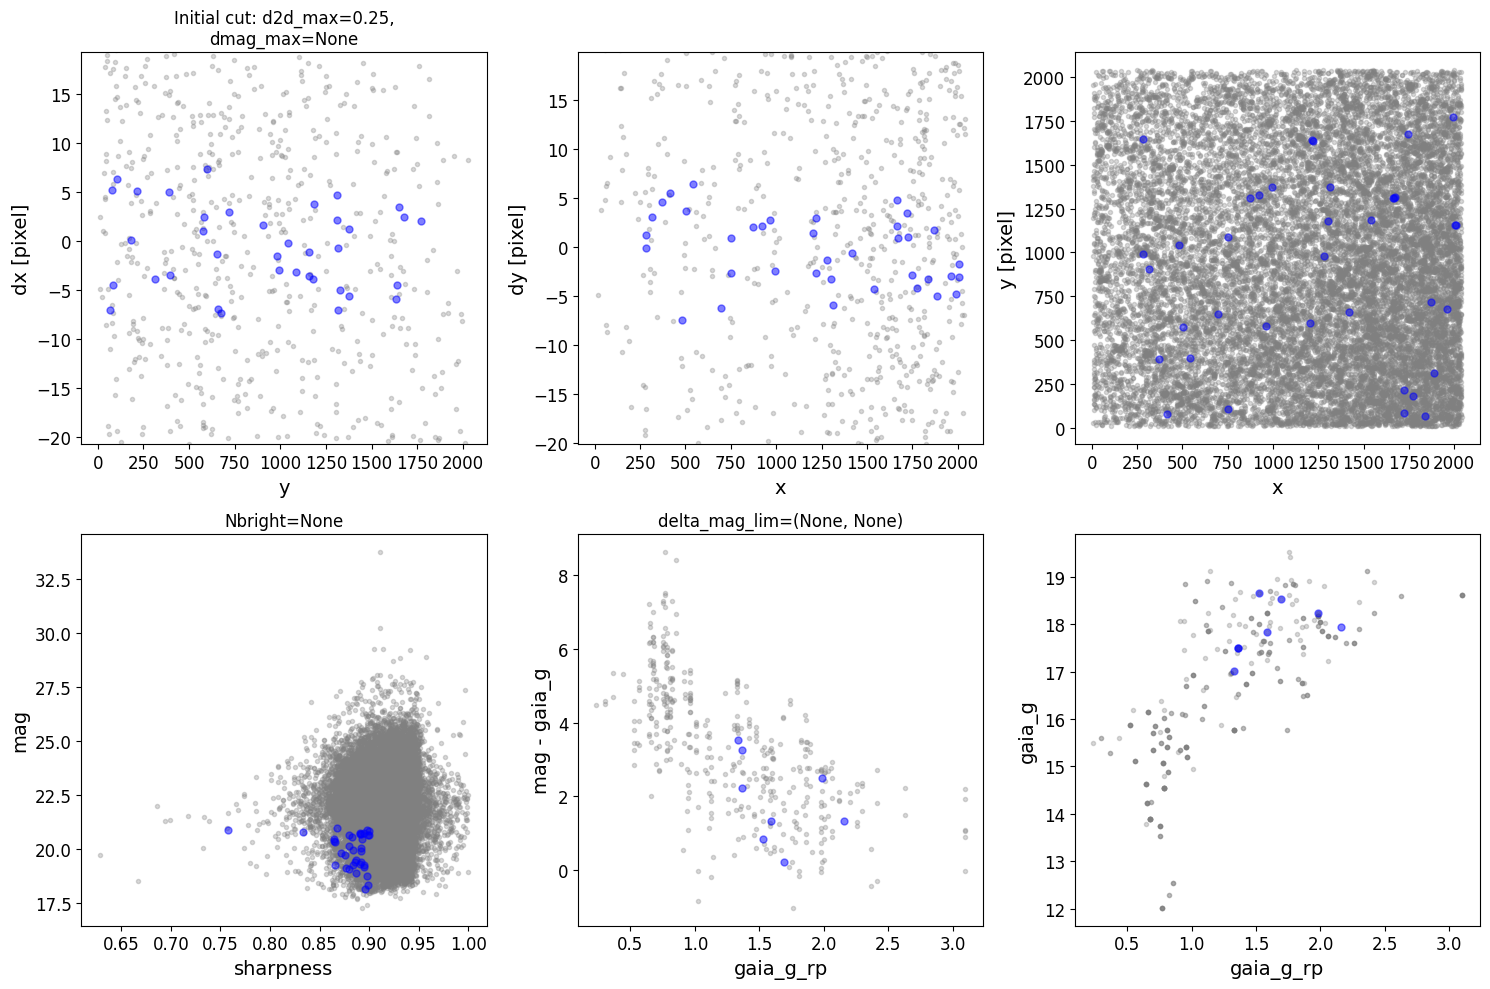

### Doing histogram cut for dx, slope_min:-0.004883 slope_max:0.004883 slope_stepsize:0.000049
Nfwhm=2.5, rough_cut_px_min=0.3, rough_cut_px_max=0.8, Nsigma=3.0
########################
### rotate dx versus y
Applying rolling gaussian:
gaussian_sigma_px=0.2, binsize=0.8, gaussian_sigma(bins)=0.25, windowsize(bins)=1 halfwindowsize(bins)=1
####BEST:
    slope  intercept  maxval  index  d_bestguess  fwhm  multimax
-0.004834       4.95     7.0     11    -3.256631   1.6     False
Setting rough_cut_px=4.0000000000000036. limits: (0.3-0.8)
Setting rough_cut_px=0.8

####################
### d_rotated cut (rough_cut_px=0.8 pixels, Nsigma=3.0)
d_rot_tmp -2.4566312388462714

rough_cut_px=0.8 pixels removes 28 from 37 entries
Keeping 9 out of 9, skippin 0 because of null values in columns d_rot_tmp
median: -3.093494
75.000000 percentile cut: max residual for cut: 0.420948
__tmp_residuals 0.4209482394332622
median: -3.039608
i:00 mean:-3.039608(0.057478) stdev:0.128524(0.037102) X2norm:0.91 Nchang

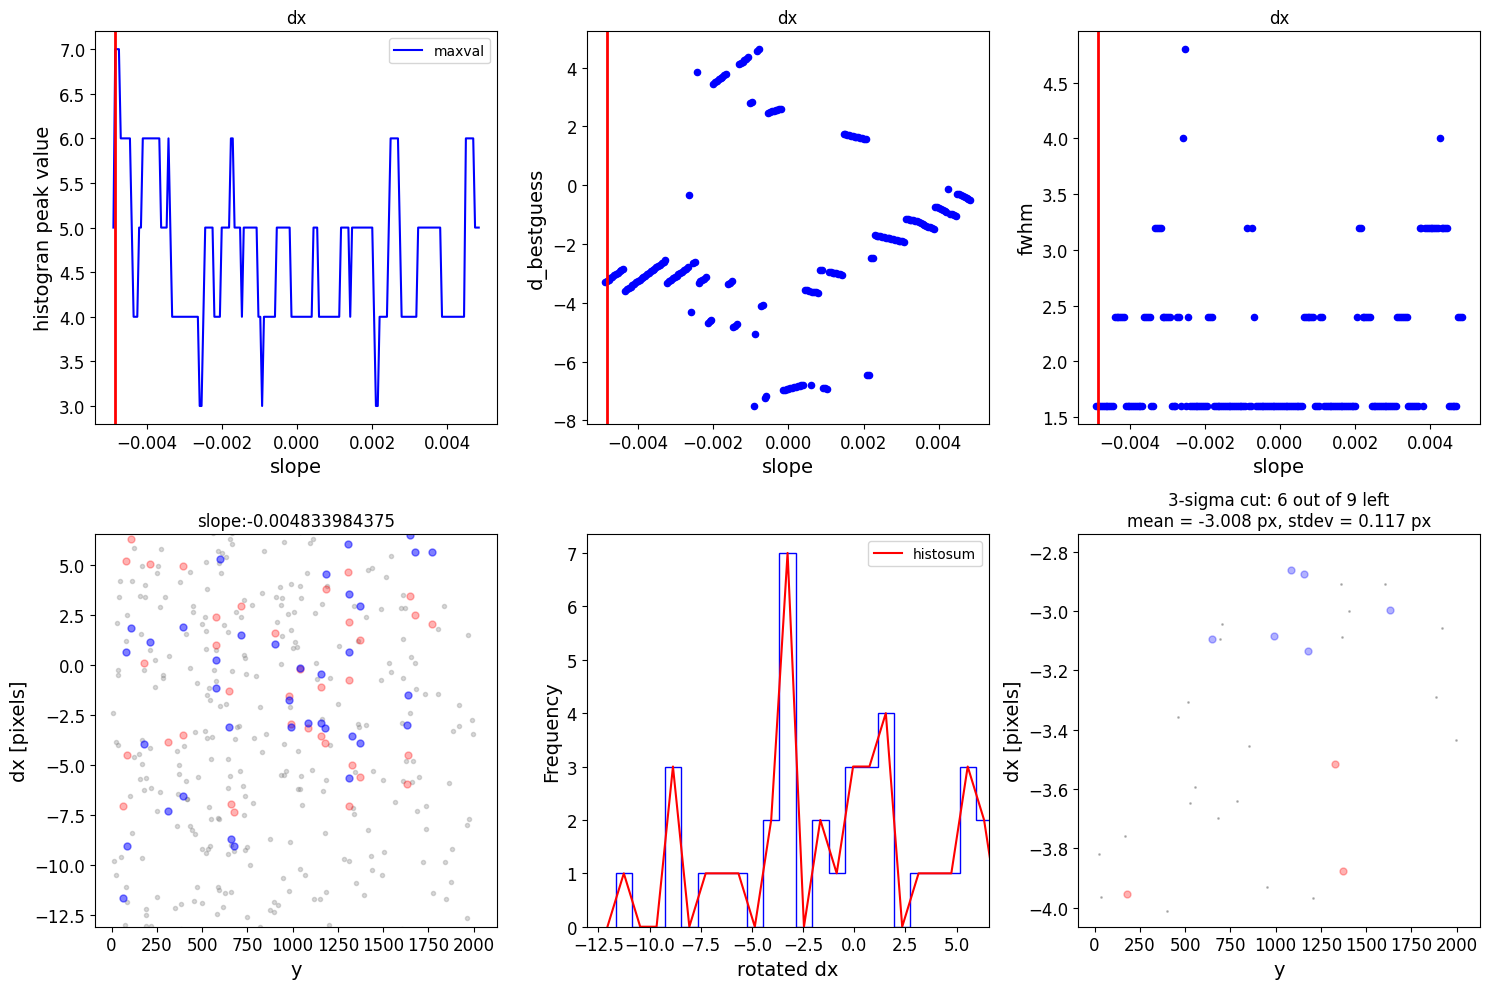

### Doing histogram cut for dy, slope_min:-0.004883 slope_max:0.004883 slope_stepsize:0.000049
Nfwhm=2.5, rough_cut_px_min=0.3, rough_cut_px_max=0.8, Nsigma=3.0
########################
### rotate dy versus x
Applying rolling gaussian:
gaussian_sigma_px=0.2, binsize=0.8, gaussian_sigma(bins)=0.25, windowsize(bins)=1 halfwindowsize(bins)=1
####BEST:
    slope  intercept  maxval  index  d_bestguess  fwhm  multimax
-0.004395        4.5     2.0      8    -1.659452   1.6     False
Setting rough_cut_px=3.999999999999999. limits: (0.3-0.8)
Setting rough_cut_px=0.8

####################
### d_rotated cut (rough_cut_px=0.8 pixels, Nsigma=3.0)
d_rot_tmp -0.8594523002555288

rough_cut_px=0.8 pixels removes 4 from 6 entries
Keeping 2 out of 2, skippin 0 because of null values in columns d_rot_tmp
median: -2.021255
i:00 mean:-2.021255(0.035805) stdev:0.035805(0.017903) X2norm:0.64 Nchanged:0 Ngood:2 Nclip:0

mean: -2.021255
i:01 mean:-2.021255(0.028569) stdev:0.028569(0.014284) X2norm:1.00 Nchanged

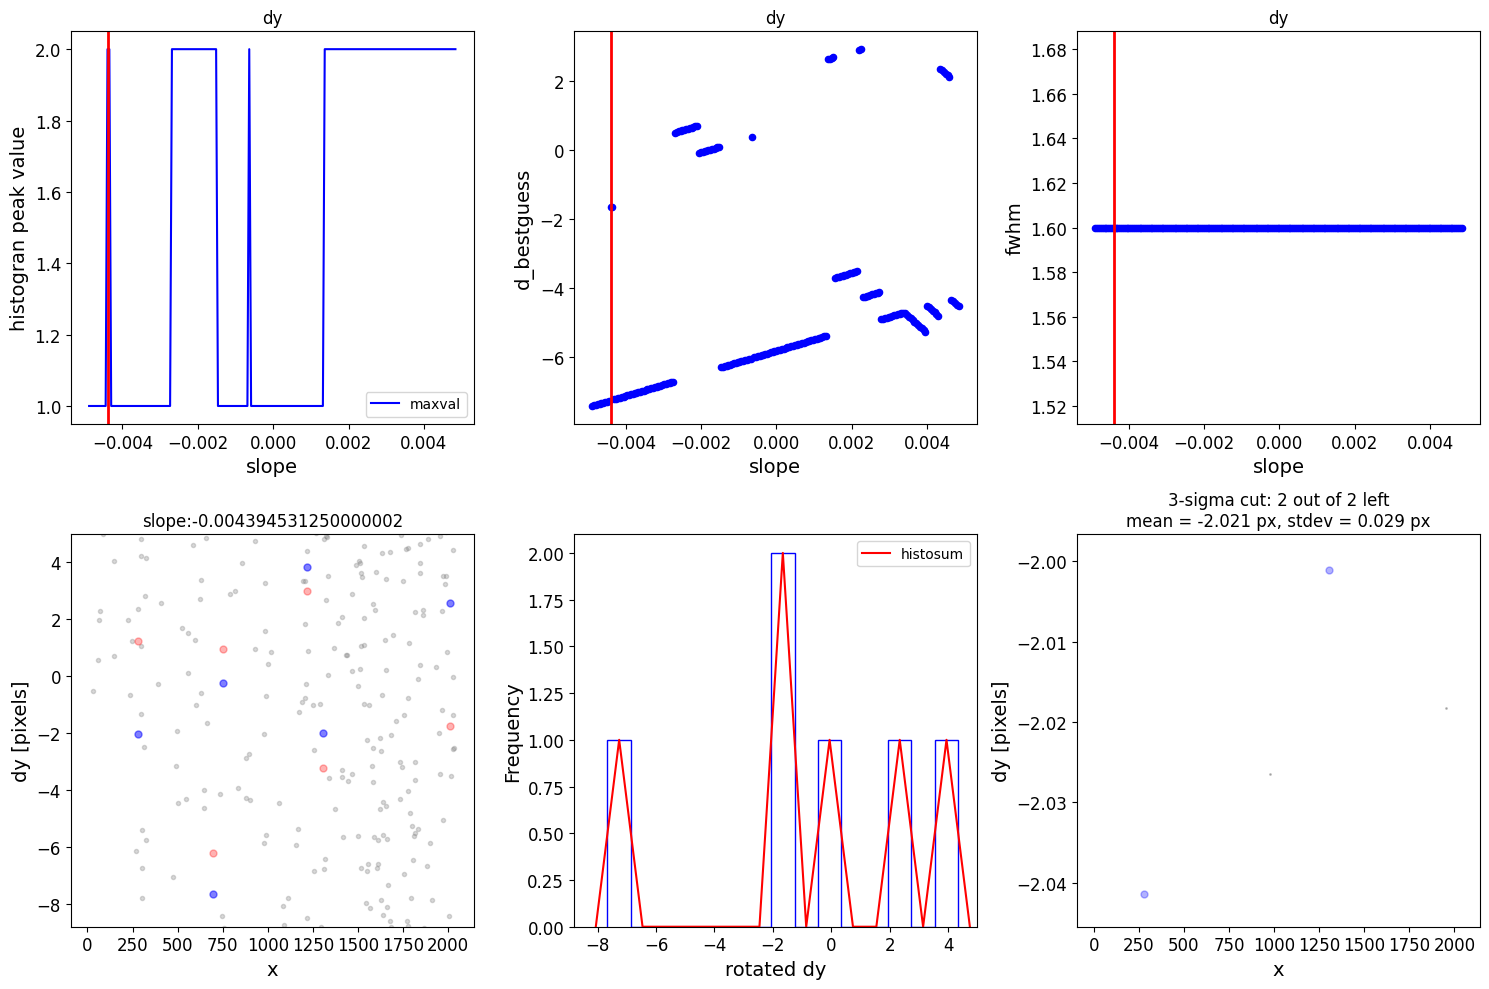

*** Note: close plots to continue!


<Figure size 640x480 with 0 Axes>

2024-09-25 16:29:52,260 - stpipe.TweakRegStep - INFO - TweakRegStep instance created.
2024-09-25 16:29:52,653 - stpipe.TweakRegStep - INFO - Step TweakRegStep running with args ([<ImageModel(2048, 2048) from jw01334001001_02101_00001_nrca4_cal.fits>],).
2024-09-25 16:29:52,658 - stpipe.TweakRegStep - INFO - Step TweakRegStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /home/aswin/hst123/jwstred_temp_gaia/jw01334001001_02101_00001_nrca4_jhat.fits
  output_dir: ./jwstred_temp_gaia
  output_ext: .fits
  output_use_model: True
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_catalogs: False
  catalog_format: ecsv
  kernel_fwhm: 2.5
  snr_threshold: 50
  brightest: 4000
  peakmax: None
  enforce_user_order: False
  expand_refcat: False
  minobj: 4
  searchrad: 0.5
  use2dhist: True
  separation: 9
  tolerance: 0.7
  xoffset: 0
  yoffset: 0
  fitgeometry: rshift
  nclip: 3
  sigma: 3.0
  align_to_

Setting output directory for jw01334001001_02101_00001_nrca4_jhat.fits file to ./jwstred_temp_gaia
2 matches are passed to tweakreg rshift fitting
Fitting tweakreg fitgeometry=rshift to xy=x,y to ra,dec=gaia_ra,gaia_dec


2024-09-25 16:29:52,696 - stpipe.TweakRegStep - INFO - NUMBER OF IMAGES: 1
2024-09-25 16:29:52,698 - stpipe.TweakRegStep - INFO - Detected 2 sources in jw01334001001_02101_00001_nrca4_cal.fits.
2024-09-25 16:29:52,732 - stpipe.TweakRegStep - INFO - 
2024-09-25 16:29:52,739 - stpipe.TweakRegStep - INFO - Number of image groups to be aligned: 1.
2024-09-25 16:29:52,741 - stpipe.TweakRegStep - INFO - Image groups:
2024-09-25 16:29:52,796 - stpipe.TweakRegStep - INFO - * Images in GROUP 'jw01334001001_02101_00001_nrca4_cal':
2024-09-25 16:29:52,797 - stpipe.TweakRegStep - INFO -      jw01334001001_02101_00001_nrca4_cal
2024-09-25 16:29:52,797 - stpipe.TweakRegStep - INFO - 
2024-09-25 16:29:52,799 - stpipe.TweakRegStep - INFO -  
2024-09-25 16:29:52,800 - stpipe.TweakRegStep - INFO - ***** tweakwcs.imalign.align_wcs() started on 2024-09-25 16:29:52.799814
2024-09-25 16:29:52,801 - stpipe.TweakRegStep - INFO -       Version 0.8.7
2024-09-25 16:29:52,802 - stpipe.TweakRegStep - INFO -  
2024

replacing SIP ./jwstred_temp_gaia/jw01334001001_02101_00001_nrca4_jhat.fits


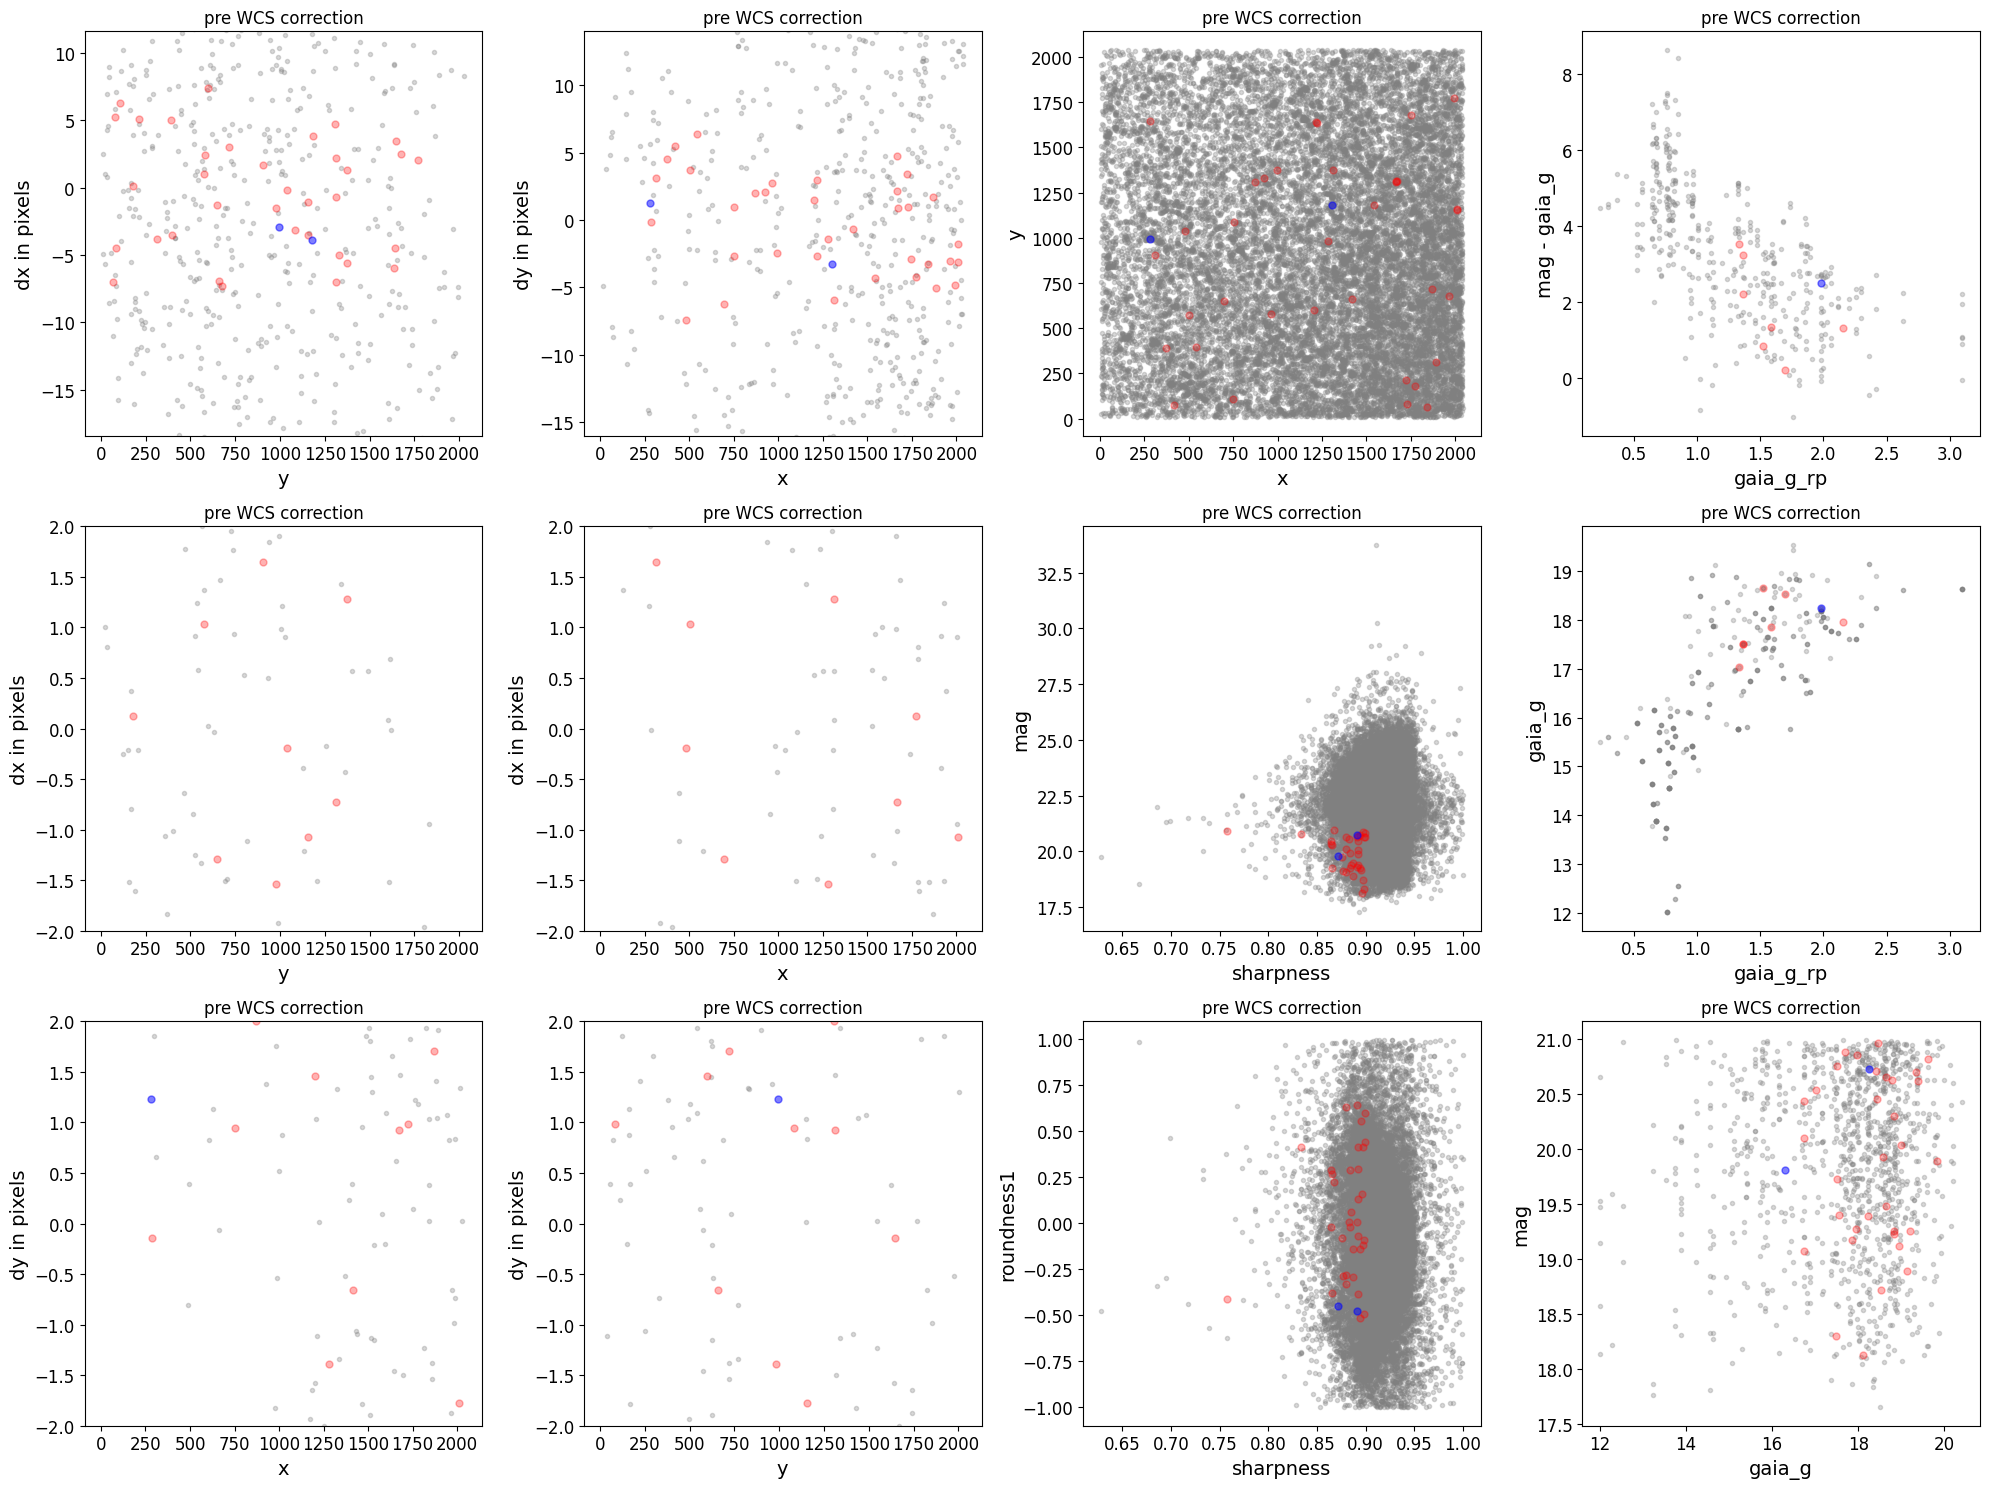

./jwstred_temp_gaia/jw01334001001_02101_00001_nrca4_jhat.fits


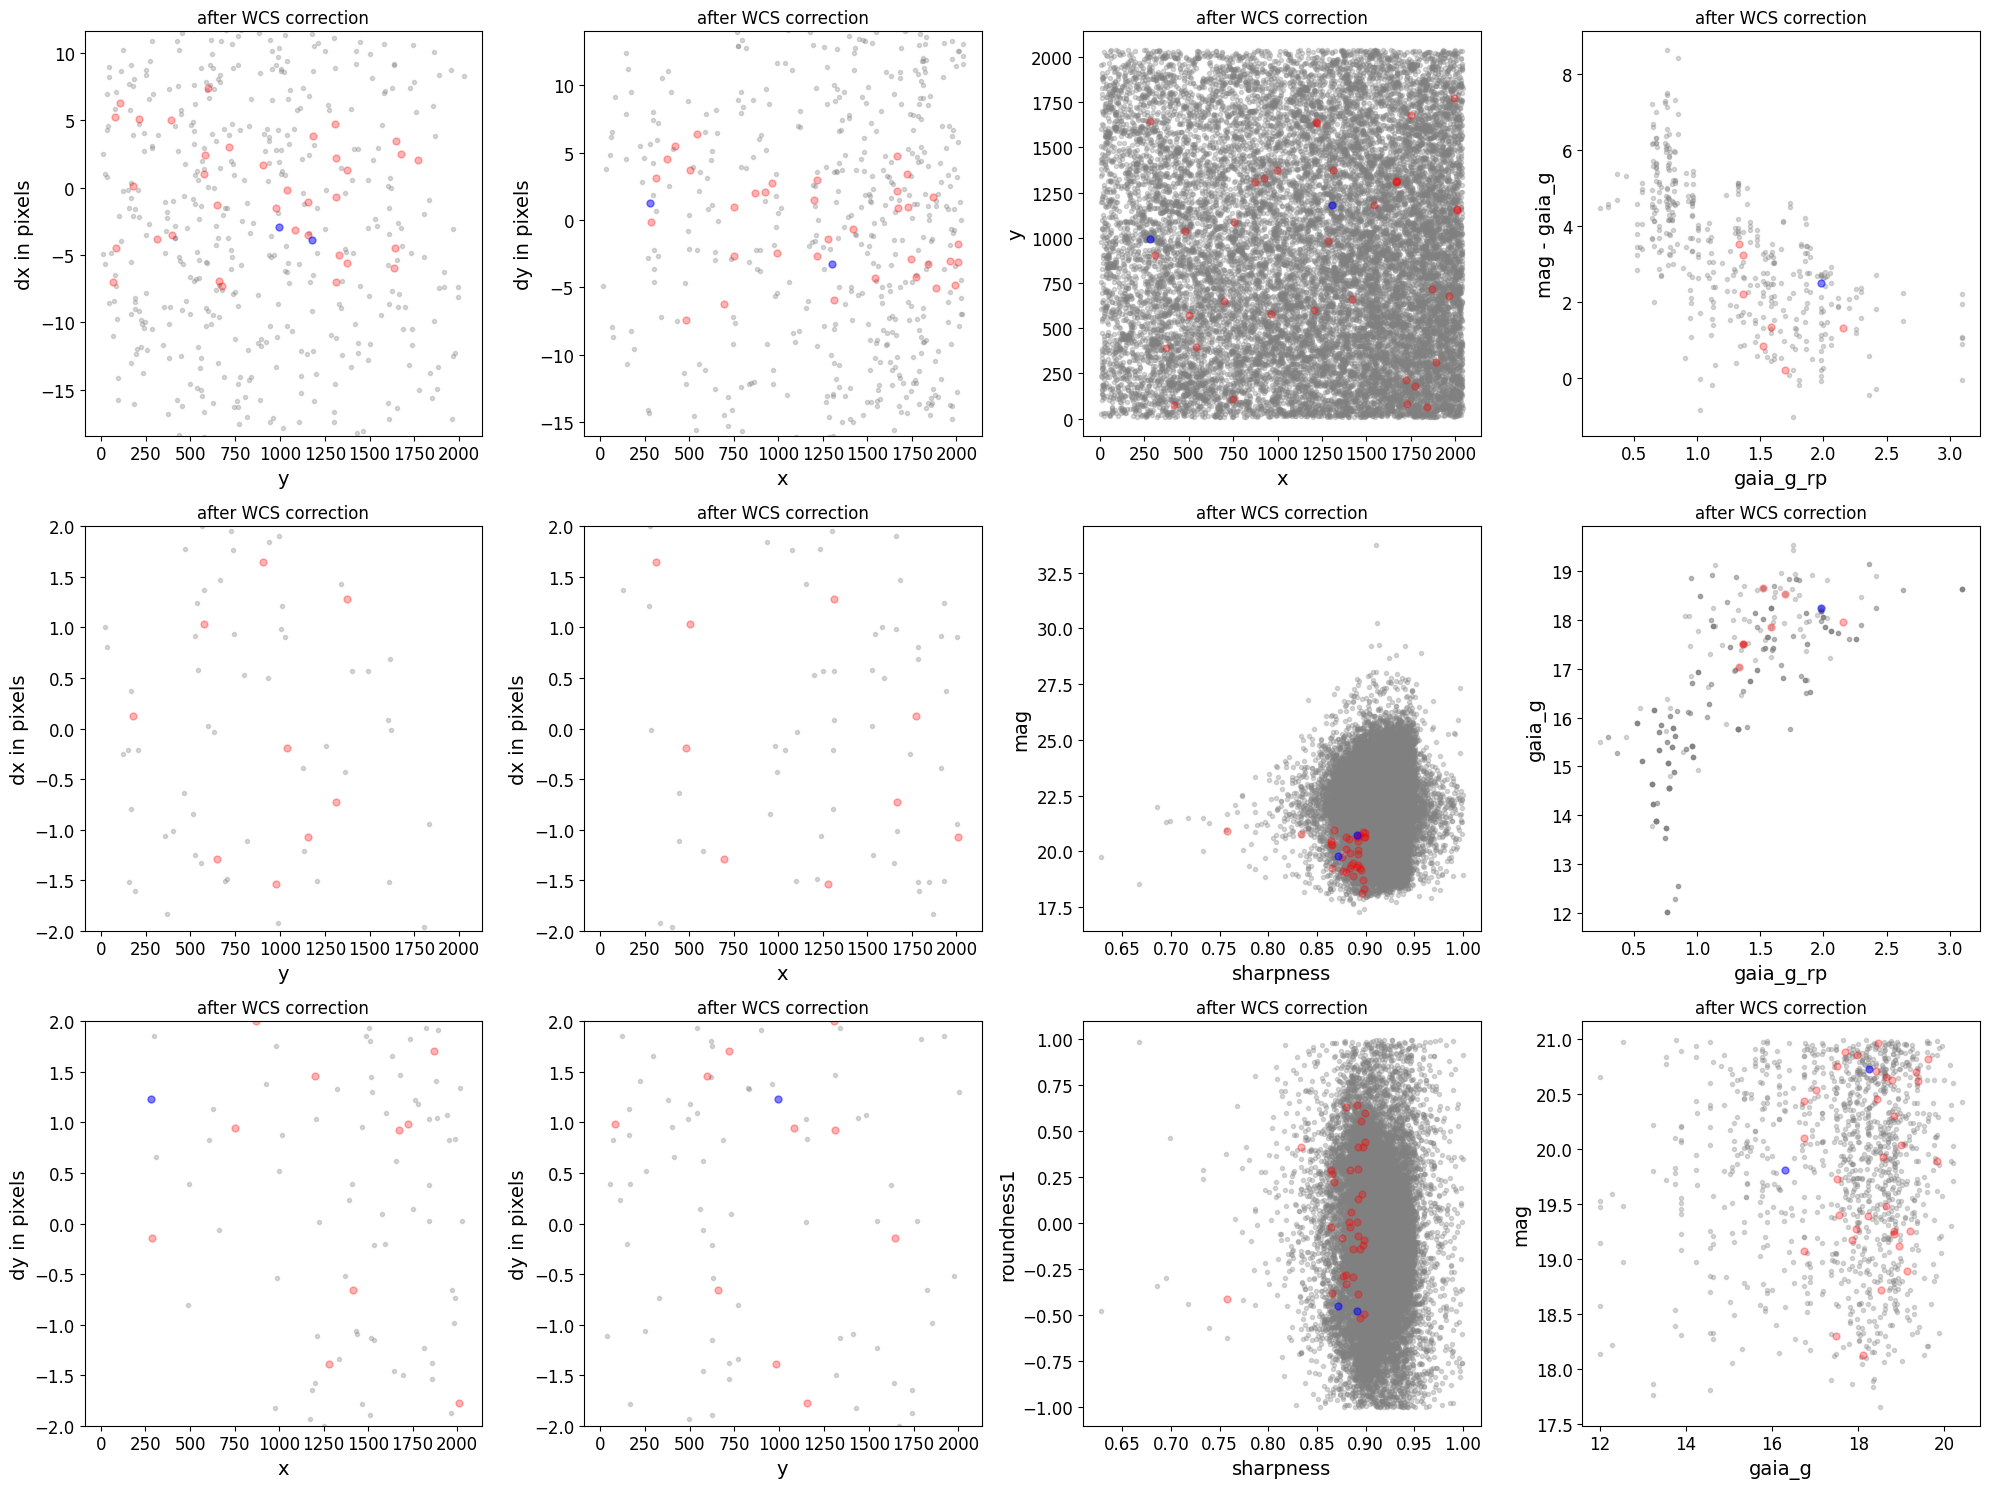

*** Note: close plots to continue!


0

In [6]:
wcs_align = st_wcs_align()
    
wcs_align.run_all(align_image,
		  telescope='jwst',
		  outsubdir='jwstred_temp_gaia',
          overwrite=True,
          d2d_max=.25,
          find_stars_threshold = 3,
          showplots=2,
          refcatname='Gaia',
          histocut_order='dxdy',
          verbose = True,
              sharpness_lim=(0.3,0.9),
              roundness1_lim=(-0.7, 0.7),
              SNR_min= 3,
              dmag_max=.1,
#               Nbright = 450,
              objmag_lim =(15,21),
              binsize_px = 0.8)

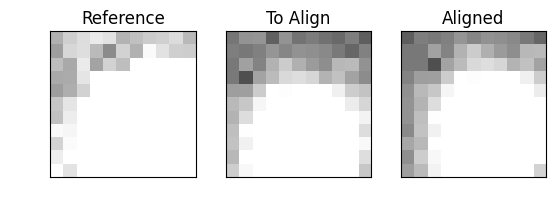

In [32]:
norm3 = simple_norm(aligned_cutout,stretch='linear',min_cut=-.5,max_cut=3)
fig,axes = plt.subplots(1,3)
axes[0].imshow(ref_cutout, origin='lower',
                      norm=norm1,cmap='gray')
axes[1].imshow(align_cutout, origin='lower',
                      norm=norm2,cmap='gray')
axes[2].imshow(aligned_cutout, origin='lower',
                      norm=norm3,cmap='gray')
axes[0].set_title('Reference')
axes[1].set_title('To Align')
axes[2].set_title('Aligned')
for i in range(3):
	axes[i].tick_params(labelcolor='none',axis='both',color='none')


plt.show()

#### Gaia xmatch

In [4]:
from jwst.datamodels import ImageModel

In [5]:
im = fits.open(align_image)

hdr = im['SCI'].header
nx = hdr['NAXIS1']
ny = hdr['NAXIS2']

image_model = ImageModel(im)

ra0,dec0 = image_model.meta.wcs(nx/2.0-1,ny/2.0-1)
coord0 = SkyCoord(ra0,dec0,unit=(u.deg, u.deg), frame='icrs')
radius_deg = []
for x in [0,nx-1]:        
    for y in [0,ny-1]:     
        ra,dec = image_model.meta.wcs(x,y)
        radius_deg.append(coord0.separation(SkyCoord(ra,dec,unit=(u.deg, u.deg), frame='icrs')).deg)
radius_deg = np.amax(radius_deg)*1.1

In [6]:
dr = 'gaiadr3'

query ="SELECT * FROM {}.gaia_source WHERE CONTAINS(POINT('ICRS',\
        {}.gaia_source.ra,{}.gaia_source.dec),\
        CIRCLE('ICRS',{},{} ,{}))=1;".format(dr,dr,dr,ra0,dec0,radius_deg)

job5 = Gaia.launch_job_async(query)
tb_gaia = job5.get_results() 
print("Number of stars:",len(tb_gaia))

2024-09-18 14:58:24,833 - stpipe - INFO - Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
Number of stars: 1446


In [7]:
tb_gaia

<Table length=1446>
    solution_id             DESIGNATION          ... libname_gspphot
                                                 ...                
       int64                   object            ...      object    
------------------- ---------------------------- ... ---------------
1636148068921376768 Gaia DR3 1360405022423774592 ...                
1636148068921376768 Gaia DR3 1360405400378561920 ...                
1636148068921376768 Gaia DR3 1360405400378562048 ...                
1636148068921376768 Gaia DR3 1360405400380332544 ...                
1636148068921376768 Gaia DR3 1360405400380332800 ...                
1636148068921376768 Gaia DR3 1360405022421437824 ...                
1636148068921376768 Gaia DR3 1360405022423778048 ...                
1636148068921376768 Gaia DR3 1360405022423778944 ...                
1636148068921376768 Gaia DR3 1360405091143265920 ...                
                ...                          ... ...             ...
1636148068921376768 Gaia DR3 1360405675256795008 ...                
1636148068921376768 Gaia DR3 1360405675256821120 ...                
1636148068921376768 Gaia DR3 1360405675256821248 ...                
1636148068921376768 Gaia DR3 1360405675260824832 ...                
1636148068921376768 Gaia DR3 1360405675260823808 ...                
1636148068921376768 Gaia DR3 1360405675260824320 ...                
1636148068921376768 Gaia DR3 1360405675260829440 ...                
1636148068921376768 Gaia DR3 1360405675262442496 ...                
1636148068921376768 Gaia DR3 1360405675262448256 ...

In [8]:
jhat_df = pd.read_csv(glob.glob(align_image.replace('.fits', '.phot.txt'))[0], sep = '\s+') #useful
# jhat_df[['x', 'y']].to_csv('region.csv', header = None, index = False)

In [9]:
jh_ra, jh_dec = jhat_df['ra'].to_numpy()*u.degree, jhat_df['dec'].to_numpy()*u.degree
jh_skycoord = SkyCoord(ra = jh_ra, dec = jh_dec)
ga_ra, ga_dec = np.array(tb_gaia['ra'])*u.degree, np.array(tb_gaia['dec'])*u.degree
ga_skycoord = SkyCoord(ra = ga_ra, dec = ga_dec)

In [10]:
dist_matched_df = xmatch_common(jh_skycoord, ga_skycoord, dist_limit=0.5)

Text(0.5, 1.0, 'jwst/gaia xmatch')

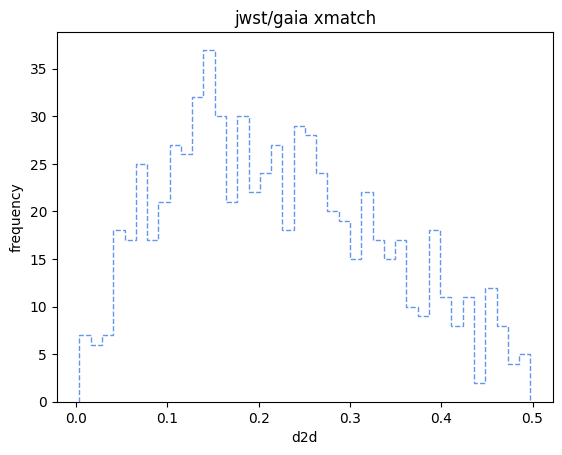

In [11]:
_ = plt.hist(dist_matched_df['d2d'], bins = 40, histtype = 'step', 
             linestyle = '--', color = 'cornflowerblue')
plt.xlabel('d2d')
plt.ylabel('frequency')
plt.title('jwst/gaia xmatch')